In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [6]:
data_path = '../data/p1ch7/'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
    )
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
    )

In [9]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [3]:
conv = nn.Conv2d(3, 16, 3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [29]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


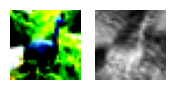

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(2, 4))

axs[0].imshow(img.permute(1, 2, 0)) # out image is darker because of normalization
axs[0].axis('off')

axs[1].imshow(output[0, 0].detach(), cmap='gray')
axs[1].axis('off');

In [40]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [41]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1./9.)

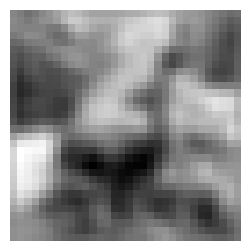

In [46]:
output = conv(img.unsqueeze(0))

plt.figure(figsize=(3, 3))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.axis('off');

In [48]:
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1., 0., 1.],
                                   [-1., 0., 1.],
                                   [-1., 0., 1.]])
    
    conv.bias.zero_()

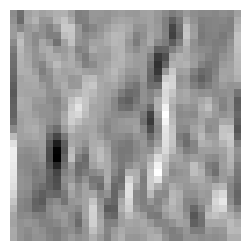

In [53]:
output = conv(img.unsqueeze(0))

plt.figure(figsize=(3, 3))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.axis('off');

In [54]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [70]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(), 
    nn.Linear(512, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [71]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [72]:
model(img.unsqueeze(0))

tensor([[-0.0312, -0.2421]], grad_fn=<AddmmBackward0>)

In [73]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, img):
        out = self.pool1(self.act1(self.conv1(img)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)

        return out

In [74]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, img):
        out = F.max_pool2d(torch.tanh(self.conv1(img)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

In [78]:
model = ConvNet()
output = model(img.unsqueeze(0))
output

tensor([[0.0349, 0.0635]], grad_fn=<AddmmBackward0>)